In [46]:
import sys
from pathlib import Path

%load_ext autoreload
%autoreload 3 -p
%matplotlib inline

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports

In [47]:
import cv2
import os
import gdown
import numpy as np
import zipfile
from PIL import Image
from augraphy import *

In [48]:
import random
random.seed(4)

## configs

In [49]:
dir_data = "../scripts/"
dir_data_raw = f"{dir_data}/images"
Path(dir_data_raw).exists()

True

In [50]:
# id = "1114s61-GmHbhIn8f9YNz6OwS3CwkOsIp&authuser=0"
# gdown.download(id=id, output="paper_textures.zip", quiet=True)

# # extract the zip
# with zipfile.ZipFile("paper_textures.zip", 'r') as zip_ref:
#     zip_ref.extractall()

# # fix the directory name
# os.rename("paper textures", "paper_textures")

In [51]:
texture_path = "paper_textures/"

In [52]:
background_textures =  ["normal",
                        "strange",
                        "rough_stains",
                        "fine_stains",
                        "severe_stains",
                        "light_stains",
                        "random_pattern",
                        "dot_granular",
                        "light_granular",
                        "rough_granular"]

edge_textures = ["curvy_edge",
                 "broken_edge"]

## eda

In [53]:
image_files = list(Path(dir_data_raw).iterdir())

In [54]:
SIZE = (320, 480)

In [55]:
img = Image.open(image_files[1])

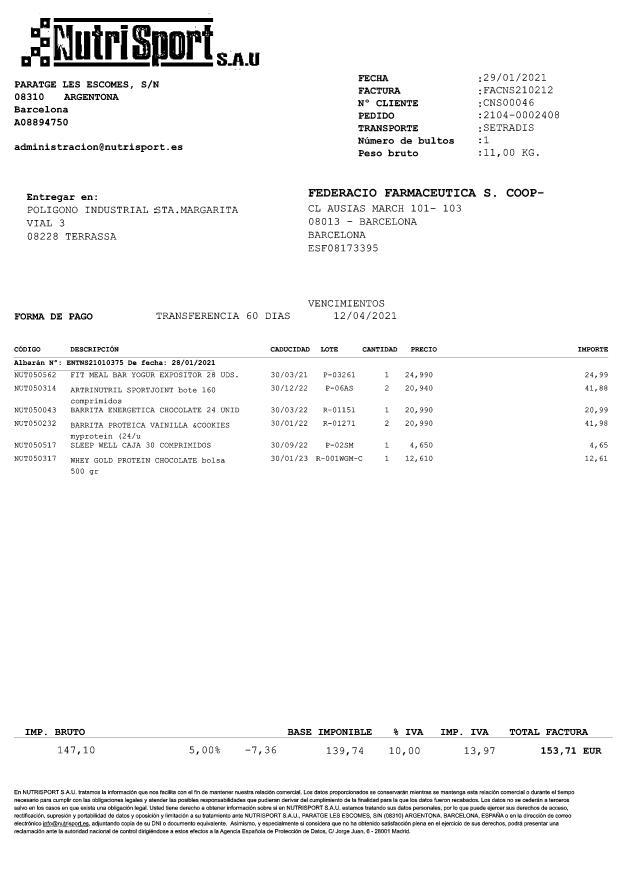

In [56]:
img

In [57]:
total_images = len(image_files)
total_images

2542

In [58]:
ratios = {
    "blank": 1.0,
    "clean": 1.0,
    "dark": 1.0,
    "blur": 1.0,
}

In [59]:
num_blanks = int(ratios["blank"]*total_images)
num_blanks

2542

## texture augs

In [18]:
from augraphy import *

def create_augraphy_pipeline():
    ink_phase = [
        Scribbles(scribbles_size_range=(20, 100)),
    ]
    paper_phase = [
        PaperFactory(texture_path=texture_path,
                                generate_texture=0,
                                blend_texture=1,
                                blend_generate_texture = 1,
                                blend_texture_edge_type = "broken_edge",
                                blend_method="ink_to_paper"),
        
        NoiseTexturize(
            sigma_range=(3, 5),
            turbulence_range=(2, 5),
            p=0.5,
        ),
        
    ]

    post_phase = []

    pipeline = AugraphyPipeline(ink_phase=ink_phase, 
                                paper_phase=paper_phase, 
                                post_phase=post_phase, overlay_type='ink_to_paper',
                                overlay_alpha=1.0)

    return pipeline

# Create and use the pipeline
pipeline = create_augraphy_pipeline()

# To use the pipeline on an image:
# augmented_image = pipeline.augment(image)['output']

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [432]:
img = Image.open(image_files[50])#.resize(SIZE)

In [454]:
out = pipeline(np.array(img.convert("RGB")))

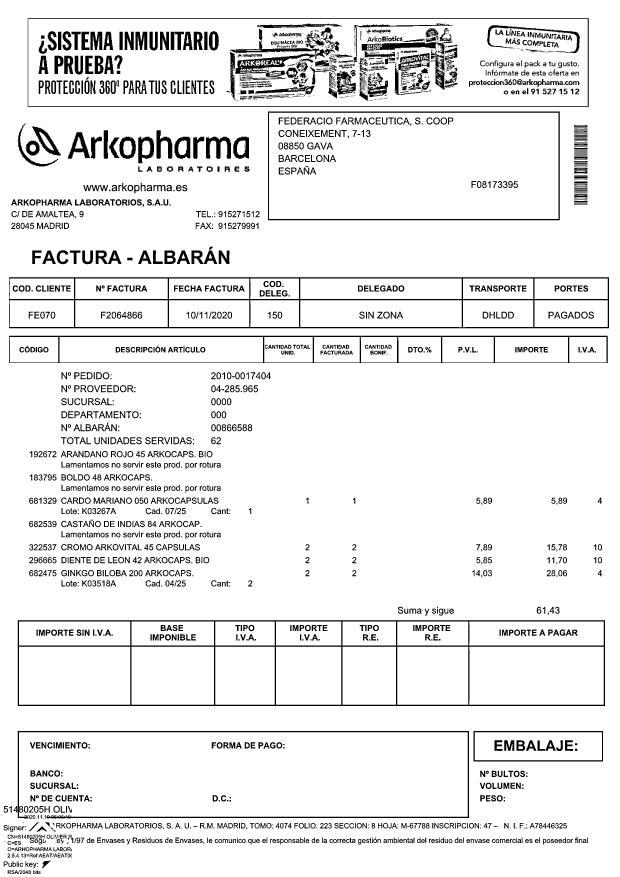

In [455]:
img

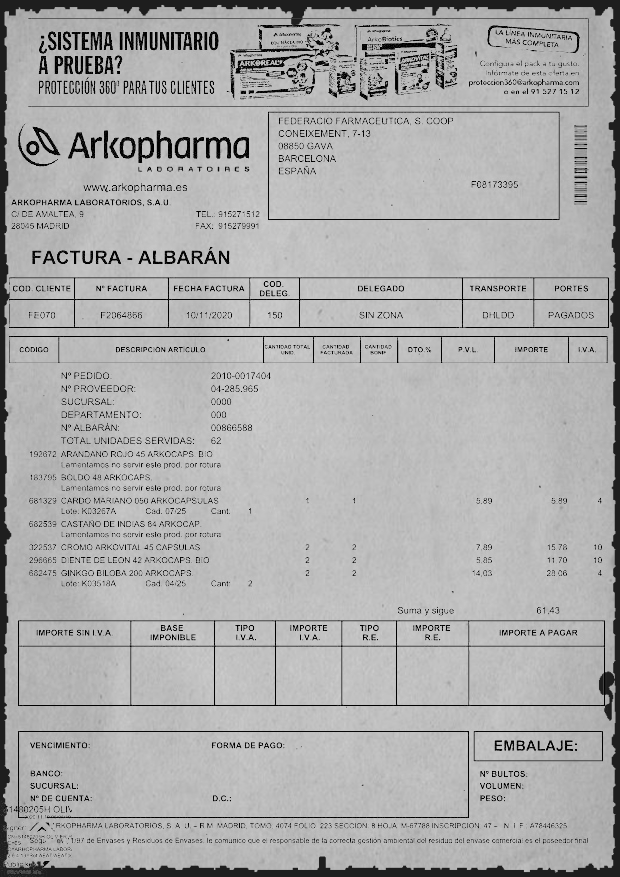

In [456]:
Image.fromarray(out)

## funcs

In [19]:
from skimage import filters
from skimage.util import crop

def is_blank_document_robust(image_path, 
                             content_threshold=0.01,
                             quadrant_threshold=0.75, crop_percentage=0.7):
    # Read image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap="gray")
    if crop_percentage < 1.0:
        crop_size = int((1 - crop_percentage) * min(image.shape) / 2)
        image = crop(image, ((crop_size, crop_size), (crop_size, crop_size)))
    # Robust binarization using Otsu's method
    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    def analyze_region(region):
        pixel_density = 1 - (np.sum(region == 255) / region.size)
        print(pixel_density)
        return pixel_density > content_threshold

    # Analyze whole image
    if analyze_region(binary):
        return False, binary # Not blank if whole image has significant content

    # Divide image into quadrants and analyze each
    h, w = binary.shape
    quadrants = [
        binary[:h//2, :w//2], binary[:h//2, w//2:],
        binary[h//2:, :w//2], binary[h//2:, w//2:]
    ]
    
    blank_quadrants = sum(not analyze_region(q) for q in quadrants)
    
    # If most quadrants are blank, consider the document blank
    return (blank_quadrants / len(quadrants) >= quadrant_threshold) , binary

In [20]:
# for img in Path("../../scratch/noisy_doc_clf/blanks/").iterdir():
#     if img.suffix == ".png":
#         print(img, is_blank_document_robust(img.as_posix())[0])

0.14137302562802345


False

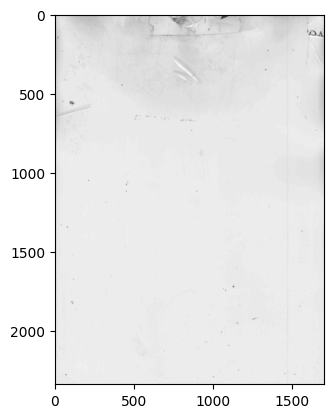

In [21]:
is_blank_document_robust("../../scratch/noisy_doc_clf/blanks/RN64306138_2024-01-18_SEN_SOF_POA_IMAGE_11527687829_358609050.png")[0]

## blanks

In [60]:
def blank_pipe_v1():
    # Create a pipeline with multiple augmentations divided into phases
    pipeline = AugraphyPipeline(
        ink_phase=[
            # Add very subtle ink marks
            Letterpress(
                n_samples=(50, 100),
                n_clusters=(50, 100),
                std_range=(1000, 2000),
                value_range=(235, 255),
                blur=1
            ),
            # Add some very faint lines
            LowInkRandomLines(
                count_range=(5, 10),
                use_consistent_lines=True,
                noise_probability=0.05
            ),
        ],
        paper_phase=[
            # Increase brightness to wash out the image
            # Brightness(brightness_range=(2.0, 3.0), min_brightness=1),
            # Add subtle paper texture
            PaperFactory(texture_path=texture_path,
                            generate_texture=0,
                            generate_texture_background_type="random",
                            texture_enable_color="random",
                            blend_generate_texture = 0,
                            blend_texture_path=texture_path,
                            blend_texture_background_type="random",
                            blend_method="ink_to_paper")
            # Add a slight color tint to simulate aged paper
            # ColorPaper(saturation_range=(10, 60), p=0.25),
        ],
        post_phase=[
            # Slightly blur the entire image
            # Add a very subtle reflected light effect
            ReflectedLight(reflected_light_smoothness=0.9,
                           reflected_light_external_max_brightness_range=(0.98, 0.99),
                           p=0.25),
        ],
        overlay_type='ink_to_paper',
        overlay_alpha=0,
        ink_color_range=(160, 220),  # Light ink color to simulate faint text
        paper_color_range=(200, 255),  # Light paper color to simulate blank-like appearance
    )
    
    return pipeline

In [61]:
def blank_pipe_v2():
    # Create a pipeline with multiple augmentations divided into phases
    pipeline = AugraphyPipeline(
        ink_phase=[
            # Add very subtle ink marks
            Letterpress(
                n_samples=(50, 100),
                n_clusters=(50, 100),
                std_range=(1000, 2000),
                value_range=(235, 255),
                blur=1
            ),
            # Add some very faint lines
            LowInkRandomLines(
                count_range=(5, 10),
                use_consistent_lines=True,
                noise_probability=0.05
            ),
        ],
        paper_phase=[
            # Increase brightness to wash out the image
            Brightness(brightness_range=(1.2, 1.8), min_brightness=1),
            # Add subtle paper texture
            OneOf([
                NoiseTexturize(sigma_range=(3, 5), turbulence_range=(2, 5)),
                # Add some subtle noise to simulate paper grain
                SubtleNoise(subtle_range=10),
            ]),
            # Add a slight color tint to simulate aged paper
            # ColorPaper(saturation_range=(10, 60), p=0.25),
        ],
        post_phase=[
            # Slightly blur the entire image
            DepthSimulatedBlur(p=0.1),
            # Add a very subtle reflected light effect
            ReflectedLight(reflected_light_smoothness=0.9,
                           reflected_light_external_max_brightness_range=(0.98, 0.99),
                           p=0.25),
        ],
        overlay_type='ink_to_paper',
        overlay_alpha=0.3,
        ink_color_range=(120, 220),  # Light ink color to simulate faint text
        # paper_color_range=(120, 255),  # Light paper color to simulate blank-like appearance
    )
    
    return pipeline

In [19]:
pipev1 = blank_pipe_v1()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [20]:
pipev2 = blank_pipe_v2()

In [21]:
img = Image.open(image_files[100]).resize(SIZE)

In [357]:
blank_like_image = pipev1(np.array(img.convert("RGB")))

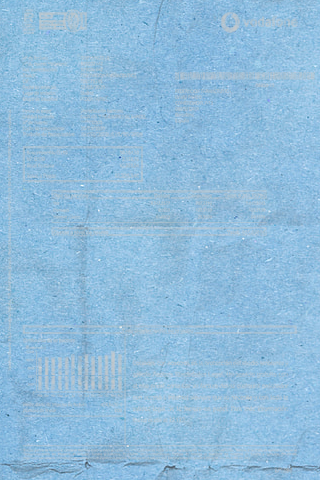

In [358]:
Image.fromarray(blank_like_image)

## blanks (v2)

In [22]:
def create_blank_document(width, height):
    return np.full((height, width, 3), 255, dtype=np.uint8)

def adjust_brightness_contrast(image):
    # Randomly adjust brightness and contrast
    alpha = np.random.uniform(0.6, 1.3)  # Contrast control
    beta = np.random.randint(-30, 30)    # Brightness control
    return cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    

def blank_pipe_v3():
    pipeline = AugraphyPipeline(
        ink_phase = [
            Dithering(p=0.5),
             OneOf([LowInkRandomLines(p=1), LowInkPeriodicLines(p=1)]),
            ],

        paper_phase = [
                PaperFactory(texture_path=texture_path,
                                generate_texture=0,
                                texture_enable_color="random",
                                blend_method="ink_to_paper")
            
        ],
        
        post_phase = [Markup(p=0.25),
                      Scribbles(p=0.5),
                      BindingsAndFasteners(p=0.25),
                      BadPhotoCopy(p=0.25),
                      ],
     overlay_alpha=0.3)
    
    return pipeline

In [23]:
pipev3 = blank_pipe_v3()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [24]:
blank_doc = create_blank_document(*SIZE)  # Adjust size as needed
degraded_doc = pipev1(blank_doc)

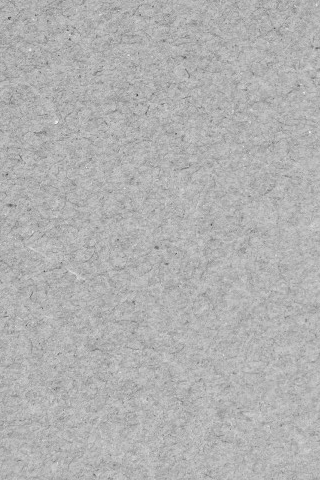

In [25]:
Image.fromarray(degraded_doc)

### blanks v3

In [6]:
import numpy as np
from PIL import Image

In [40]:
def generate_blank_document(
    min_width=500,
    max_width=1600,
    min_height=700,
    max_height=2000,
    min_brightness=220,
    max_brightness=255,
    noise_intensity=5
):
    # Generate random width and height within the specified range
    width = np.random.randint(min_width, max_width + 1)
    height = np.random.randint(min_height, max_height + 1)
    
    # Generate a base color (slightly off-white)
    base_color = np.random.randint(min_brightness, max_brightness + 1)
    
    # Create the base image array
    image_array = np.full((height, width, 3), base_color, dtype=np.uint8)
    
    # Add random noise
    noise = np.random.randint(-noise_intensity, noise_intensity + 1, size=(height, width, 3))
    image_array = np.clip(image_array + noise, 0, 255).astype(np.uint8)
    
    # Add some subtle patterns or variations (e.g., slightly darker edges)
    edge_darkness = np.random.randint(5, 15)
    image_array[:10, :] -= edge_darkness
    image_array[-10:, :] -= edge_darkness
    image_array[:, :10] -= edge_darkness
    image_array[:, -10:] -= edge_darkness
    
    # Create and return the image
    image = Image.fromarray(image_array)
    return image

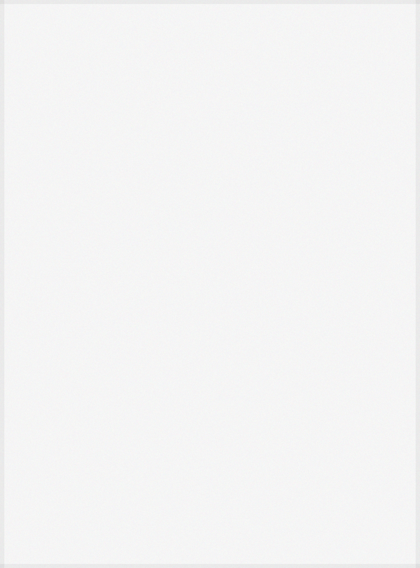

In [41]:
generate_blank_document().resize((420, 568))

## blurs

In [62]:
def apply_cv2_blur(image, blur_type='gaussian', kernel_size=5):
    """
    Apply blur to an image using OpenCV.
    
    :param image: Input image (numpy array)
    :param blur_type: Type of blur ('gaussian', 'median', or 'motion')
    :param kernel_size: Size of the blurring kernel
    :return: Blurred image
    """
    # image = increase_contrast_stretching(image)
    if blur_type == 'gaussian':
        return cv2.GaussianBlur(image, (5, 5), 0)
    elif blur_type == 'median':
        return cv2.medianBlur(image, 3)
    elif blur_type == 'motion':
        kernel = np.zeros((3, 3))
        kernel[int((3-1)/2), :] = np.ones(3)
        kernel = kernel / 3
        return cv2.filter2D(image, -1, kernel)
    else:
        raise ValueError("Invalid blur type. Choose 'gaussian', 'median', or 'motion'.")


In [89]:
def apply_random_blur(image, chosen_blur=None):
    blur_types = ['vertical', 'horizontal', 'gaussian', 'median']
    chosen_blur = chosen_blur or random.choice(blur_types)
    ks1 = (1, 3)
    ks2 = (5, 7, 9)
    if chosen_blur == 'vertical':
        return cv2.blur(image, (random.choice(ks1), random.choice(ks2)))
    elif chosen_blur == 'horizontal':
        return cv2.blur(image, (random.choice(ks2), random.choice(ks1)))
    elif chosen_blur == 'gaussian':
        return cv2.GaussianBlur(image, (random.choice(ks2), random.choice(ks2)), 0)
    else:
        return cv2.medianBlur(image, 3)


In [64]:
def blurred_pipe_v1():
    pipeline = AugraphyPipeline(
        ink_phase=[
            # Add some text-like structures before blurring
            # Letterpress(
            #     n_samples=(200, 400),
            #     n_clusters=(100, 200),
            #     std_range=(500, 1000),
            #     value_range=(0, 50),
            #     blur=1  # We'll blur later
            # ),
            # # Add some lines to simulate text or document structure
            # LowInkRandomLines(
            #     count_range=(10, 20),
            #     use_consistent_lines=True,
            #     noise_probability=0.1
            # ),
        ],
        paper_phase=[
            # Add subtle paper texture
            OneOf([
                NoiseTexturize(sigma_range=(2, 4), turbulence_range=(2, 4)),
                # PaperFactory(texture_path=texture_path,
                #              generate_texture=0,
                #              generate_texture_background_type="random",
                #              generate_texture_edge_type="broken_edge",
                #              texture_enable_color=0,
                #              blend_texture=1,
                #              blend_generate_texture=0,
                #              blend_texture_path=texture_path,
                #              blend_texture_background_type="random",
                #              blend_texture_edge_type="broken_edge",
                #              blend_method="ink_to_paper")
            ]),
            # Slight color variation
            ColorPaper(hue_range=(0, 20), saturation_range=(0, 20), p=0.5),
        ],
        post_phase=[
            OneOf([
                # DepthSimulatedBlur(blur_major_axes_length_range=(180, 360),
                #                   blur_minor_axes_length_range=(180, 360)),
                DoubleExposure(gaussian_kernel_range=(5, 9),
                        offset_direction="random",
                        offset_range=(2, 5),
                    )
            ]),
            # Brightness(brightness_range=(0.9, 1.1)),
        ],
        overlay_type='ink_to_paper',
        overlay_alpha=1.0,
        ink_color_range=(0, 50),  # Darker ink to make blur more visible
    )
    
    return pipeline

In [65]:
blur_pipev1 = blurred_pipe_v1()

In [66]:
img = Image.open(image_files[2]).resize(SIZE)

In [67]:
blur_like_image = blur_pipev1(np.array(img.convert("RGB")))

In [68]:
# blur_like_image = apply_random_blur(np.array(img.convert("RGB")), "median")

In [69]:
# blur_like_image = increase_contrast_stretching(blur_like_image, low_percentile=2, high_percentile=98)

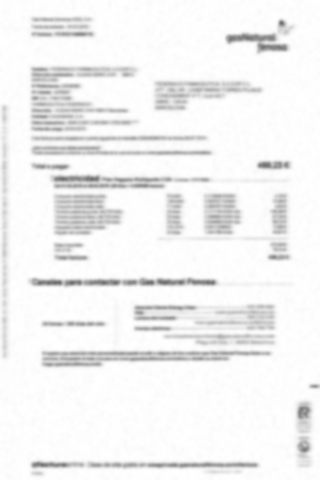

In [70]:
Image.fromarray(blur_like_image)

## darks

In [128]:
from augraphy.default.pipeline import * 

In [522]:
def dark_image_pipe_v1():
    ink_phase = [
        LinesDegradation(
            line_roi=(0.0, 0.0, 1.0, 1.0),
            line_gradient_range=(32, 255),
            line_gradient_direction=(0, 2),
            line_split_probability=(0.2, 0.4),
            line_replacement_value=(5, 10),
            line_min_length=(30, 40),
            line_long_to_short_ratio=(5, 7),
            line_replacement_probability=(0.4, 0.5),
            line_replacement_thickness=(1, 3),
            p=0.5,
        ),
        # InkBleed(
        #     intensity_range=(0.1, 0.4),
        #     kernel_size=(7, 7),
        #     severity=(0.4, 0.6),
        #     p=0.5,
        # ),
        LowInkRandomLines(
            count_range=(3, 12),
            use_consistent_lines=False,
            noise_probability=0.16,
            p=0.5,
        ),
    ]
    paper_phase = [
        PaperFactory(texture_path=texture_path,
                                blend_method="ink_to_paper"),
        OneOf([
            ColorPaper(
                hue_range=(0, 255),
                saturation_range=(10, 40),
            ),
            BrightnessTexturize(
                texturize_range=(0.9, 0.99),
                deviation=0.03,
            ),
        ]),
        # NoiseTexturize(
        #     sigma_range=(3, 10),
        #     turbulence_range=(2, 5),
        #     p=0.5,
        # ),
        
    ]

    post_phase = [
        Brightness(brightness_range=(0.3, 0.6), min_brightness=0, p=0.8),
        OneOf([
            SubtleNoise(subtle_range=5),
            ColorShift(
                    color_shift_offset_x_range=(1, 3),
                    color_shift_offset_y_range=(1, 3),
                    color_shift_iterations=(1, 2),
                    color_shift_brightness_range=(0.7, 0.9),
                ),
            Jpeg(
                quality_range=(25, 95),
            ),
        ]),
        
        ShadowCast(
            shadow_side="random",
            shadow_vertices_range=(5, 20),
            shadow_width_range=(0.3, 0.8),
            shadow_height_range=(0.3, 0.8),
            shadow_color=(50, 50, 50),
            shadow_opacity_range=(0.2, 0.6),
            shadow_iterations_range=(2, 4),
            shadow_blur_kernel_range=(101, 301),
            p=0.8,
        ),
        ReflectedLight(
                reflected_light_smoothness=1,
                reflected_light_internal_radius_range=(0.2, 0.4),
                reflected_light_external_radius_range=(0.4, 0.6),
                reflected_light_internal_max_brightness_range=(0.1, 0.2),
                reflected_light_external_max_brightness_range=(0.1, 0.2),
                p=0.5
            ),
    ]

    pipeline = AugraphyPipeline(ink_phase=ink_phase, 
                                paper_phase=paper_phase, 
                                post_phase=post_phase, overlay_type='multiply',
                                overlay_alpha=0.7,
                                ink_color_range=(0, 120),  # Dark ink color
                                paper_color_range=(50, 150))  # Darker paper color)

    return pipeline

In [523]:
def dark_image_pipe_v2():
    ink_phase = [
        InkBleed(
            intensity_range=(0.1, 0.4),
            kernel_size=(3, 3),
            severity=(0.4, 0.6),
            p=0.5,
        ),
        Scribbles(),
        
    ]
    paper_phase = [
        PaperFactory(texture_path=texture_path,
                                blend_method="ink_to_paper"),
        NoiseTexturize(
            sigma_range=(3, 5),
            turbulence_range=(2, 5),
            p=0.5,
        ),
        
    ]

    post_phase = [
        Brightness(brightness_range=(0.5, 0.8), min_brightness=0, p=0.8),
        ShadowCast(
            shadow_side="random",
            shadow_vertices_range=(5, 20),
            shadow_width_range=(0.3, 0.8),
            shadow_height_range=(0.3, 0.8),
            shadow_color=(50, 50, 50),
            shadow_opacity_range=(0.2, 0.6),
            shadow_iterations_range=(2, 4),
            shadow_blur_kernel_range=(101, 301),
            p=1,
        ),
    ]

    pipeline = AugraphyPipeline(ink_phase=ink_phase, 
                                paper_phase=paper_phase, 
                                post_phase=post_phase, overlay_type='ink_to_paper',
                                overlay_alpha=0.6,
                                ink_color_range=(0, 40),  # Dark ink color
                                paper_color_range=(50, 150))  # Darker paper color)

    return pipeline

In [524]:
dark_pipev1 = dark_image_pipe_v1()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [525]:
dark_pipev2 = dark_image_pipe_v2()

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [526]:
img = Image.open(image_files[14]).resize(SIZE)

In [527]:
dark_like_image = dark_pipev1(np.array(img.convert("RGB")))

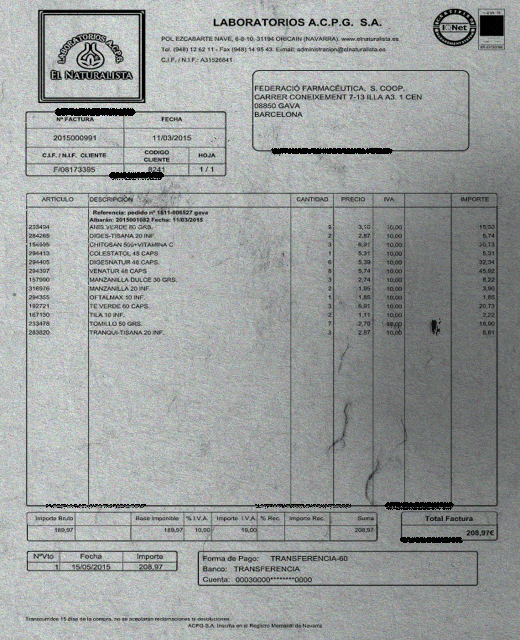

In [528]:
Image.fromarray(dark_like_image)

## generation

In [71]:
import os
import random
from tqdm.notebook import tqdm

In [72]:
dir_data_gen = "../data/dataset4"

In [73]:
Path(dir_data_raw).exists()

True

In [74]:
config = {
    "input_folder": dir_data_raw,
    "output_folder": dir_data_gen,
    "total_images": len(image_files),
    "ratios": ratios,
    "image_size": None
}

In [75]:
SIZE

(320, 480)

In [76]:
dir_data_raw

'../scripts//images'

In [77]:
def load_and_shuffle_images(input_folder):
    image_files = [Path(f).name for f in os.listdir(input_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(image_files)
    return image_files

In [78]:
image_files_shuffled = load_and_shuffle_images(config["input_folder"])
total_original = len(image_files_shuffled)
total_original

2542

In [79]:
categories = {
        "blank": int(total_images * ratios['blank']),
        "clean": int(total_images * ratios['clean']),
        "dark": int(total_images * ratios['dark']),
        "blur": int(total_images * ratios['blur']),
    }

### cleans

In [44]:
image_files_shuffled[0]

'doceosoftware_01522.jpg'

In [45]:
import shutil

In [46]:
def copy_clean_images(source_folder, destination_folder, image_files):
    clean_folder = os.path.join(destination_folder, 'clean')
    os.makedirs(clean_folder, exist_ok=True)
    
    # Copy the specified number of images
    for i, image_file in enumerate(tqdm(image_files, desc="Copying clean images")):
        source_path = os.path.join(source_folder, image_file)
        destination_path = os.path.join(clean_folder, f"clean_{i:05d}{os.path.splitext(image_file)[1]}")
        shutil.copy(source_path, destination_path)
        # Image.open(source_path).resize(SIZE).save(destination_path)

In [47]:
copy_clean_images(dir_data_raw, dir_data_gen, image_files_shuffled)

Copying clean images:   0%|          | 0/2542 [00:00<?, ?it/s]

### blanks

In [37]:
SIZE = (520, 640)

In [44]:
def generate_blanks(count, input_folder, output_folder):
    category = "blank"
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)
    # source_images_v1 = random.sample(cleans, int(count * 0.3))
    # source_images_v2 = random.sample(cleansv2, int(count * 0.3))
    # source_images_v3 = [create_blank_document(*SIZE) for _ in range(int(count * 1.0))]
    # source_images_v4 = [generate_blank_document() for _ in range(int(count*0.2))]
    # pipe_v1 = create_blank_image_pipeline()
    # pipe_v2 = degrade_document
    
    # for i, img_source in enumerate(tqdm(source_images_v1, desc=f"Processing blanks", leave=False)):
    #     img = cv2.imread(os.path.join(input_folder, img_source))
    #     img = cv2.resize(img, SIZE)
    #     img = pipev1(img)
        
    #     output_path = os.path.join(output_folder, category, f"{category}_{i:05d}.png")
    #     cv2.imwrite(output_path, img)

    # for i, img_source in enumerate(tqdm(source_images_v2, desc=f"Processing blanks", leave=False)):
    #     img = cv2.imread(os.path.join(input_folder, img_source))
    #     img = cv2.resize(img, SIZE)
    #     img = pipev2(img)
        
    #     output_path = os.path.join(output_folder, category, f"{category}_v2_{i:05d}.png")
    #     cv2.imwrite(output_path, img)
    # for i, img_source in enumerate(tqdm(source_images_v3, desc=f"Processing blanks", leave=False)):
    #     img = img_source
    #     img = cv2.resize(img, SIZE)
    #     img = pipev3(img)
        
    #     output_path = os.path.join(output_folder, category, f"{category}_v3_{i:05d}.png")
    #     cv2.imwrite(output_path, img)

    for i in tqdm(range(int(count*0.2)), desc=f"Processing blanks", leave=False):
        img = np.array(create_blank_document(*SIZE))
        output_path = os.path.join(output_folder, category, f"{category}_v6_{i:05d}.png")
        cv2.imwrite(output_path, img)

In [45]:
generate_blanks(categories["blank"], dir_data_raw, dir_data_gen)

Processing blanks:   0%|          | 0/508 [00:00<?, ?it/s]

### blurs

In [83]:
SIZE = (520, 640)

In [84]:
from sklearn.model_selection import train_test_split

In [85]:
from fastai.vision.all import get_image_files

In [90]:
def generate_blurs(count, input_folder, output_folder, image_files):
    category = "blur"
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)
    total = len(image_files)
    source_v1, source_v2 = train_test_split(image_files, train_size=0.5, test_size=0.5)

    blur_types = ["gaussian", "median"]
    
    for i, img_source in enumerate(tqdm(source_v1, desc=f"Processing blurs", leave=False)):
        img = np.array(Image.open(Path(input_folder) / img_source).convert("RGB").resize((SIZE)))
        img = apply_random_blur(img)
        
        output_path = os.path.join(output_folder, category, f"{category}_v3_{i:05d}.png")
        cv2.imwrite(output_path, img)

    for i, img_source in enumerate(tqdm(source_v2, desc=f"Processing blurs", leave=False)):
        img = np.array(Image.open(Path(input_folder) / img_source).convert("RGB").resize((SIZE)))
        img = blur_pipev1(img)

        
        output_path = os.path.join(output_folder, category, f"{category}_v4_{i:05d}.png")
        cv2.imwrite(output_path, img)



In [91]:
generate_blurs(categories["blur"], dir_data_raw, dir_data_gen, image_files_shuffled)

Processing blurs:   0%|          | 0/1271 [00:00<?, ?it/s]

Processing blurs:   0%|          | 0/1271 [00:00<?, ?it/s]

### darks

In [529]:
def generate_darks(count, input_folder, output_folder, image_files):
    category = "dark"
    os.makedirs(os.path.join(output_folder, category), exist_ok=True)
    total = len(image_files)
    source_v1, source_v2 = train_test_split(image_files, train_size=0.5, test_size=0.5)
    
    for i, img_source in enumerate(tqdm(source_v1, desc=f"Processing darks", leave=False)):
        img = np.array(Image.open(Path(input_folder) / img_source).convert("RGB").resize((SIZE)))
        img = dark_pipev1(img)
        
        output_path = os.path.join(output_folder, category, f"{category}_{i:05d}.png")
        cv2.imwrite(output_path, img)

    for i, img_source in enumerate(tqdm(source_v2, desc=f"Processing darks", leave=False)):
        img = np.array(Image.open(Path(input_folder) / img_source).convert("RGB").resize((SIZE)))
        img = dark_pipev2(img)
        
        output_path = os.path.join(output_folder, category, f"{category}_v2_{i:05d}.png")
        cv2.imwrite(output_path, img)



In [530]:
generate_darks(categories["dark"], dir_data_raw, dir_data_gen, image_files_shuffled)

Processing darks:   0%|          | 0/1271 [00:00<?, ?it/s]

Processing darks:   0%|          | 0/1271 [00:00<?, ?it/s]